  master_index       county                            health_level  \
0     ID_VBWWP  uasin gishu  sub county hospitals and nursing homes   
1     ID_XMBBY  uasin gishu             national referral hospitals   
2     ID_JZNZW       kiambu  sub county hospitals and nursing homes   
3     ID_QOQTK  uasin gishu             national referral hospitals   
4     ID_ZFJBM  uasin gishu             national referral hospitals   

   years_of_experience                                             prompt  \
0                 18.0  i am a nurse with 18 years of experience in ge...   
1                 17.0  i am a nurse with 17 years of experience in ge...   
2                 12.0  i am a nurse with 12 years of experience in ge...   
3                 12.0  i am a nurse with 12 years of experience in pr...   
4                 16.0  i am a nurse with 16 years of experience in ge...   

          nursing_competency     clinical_panel  \
0  pediatric emergency burns            surgery   
1       

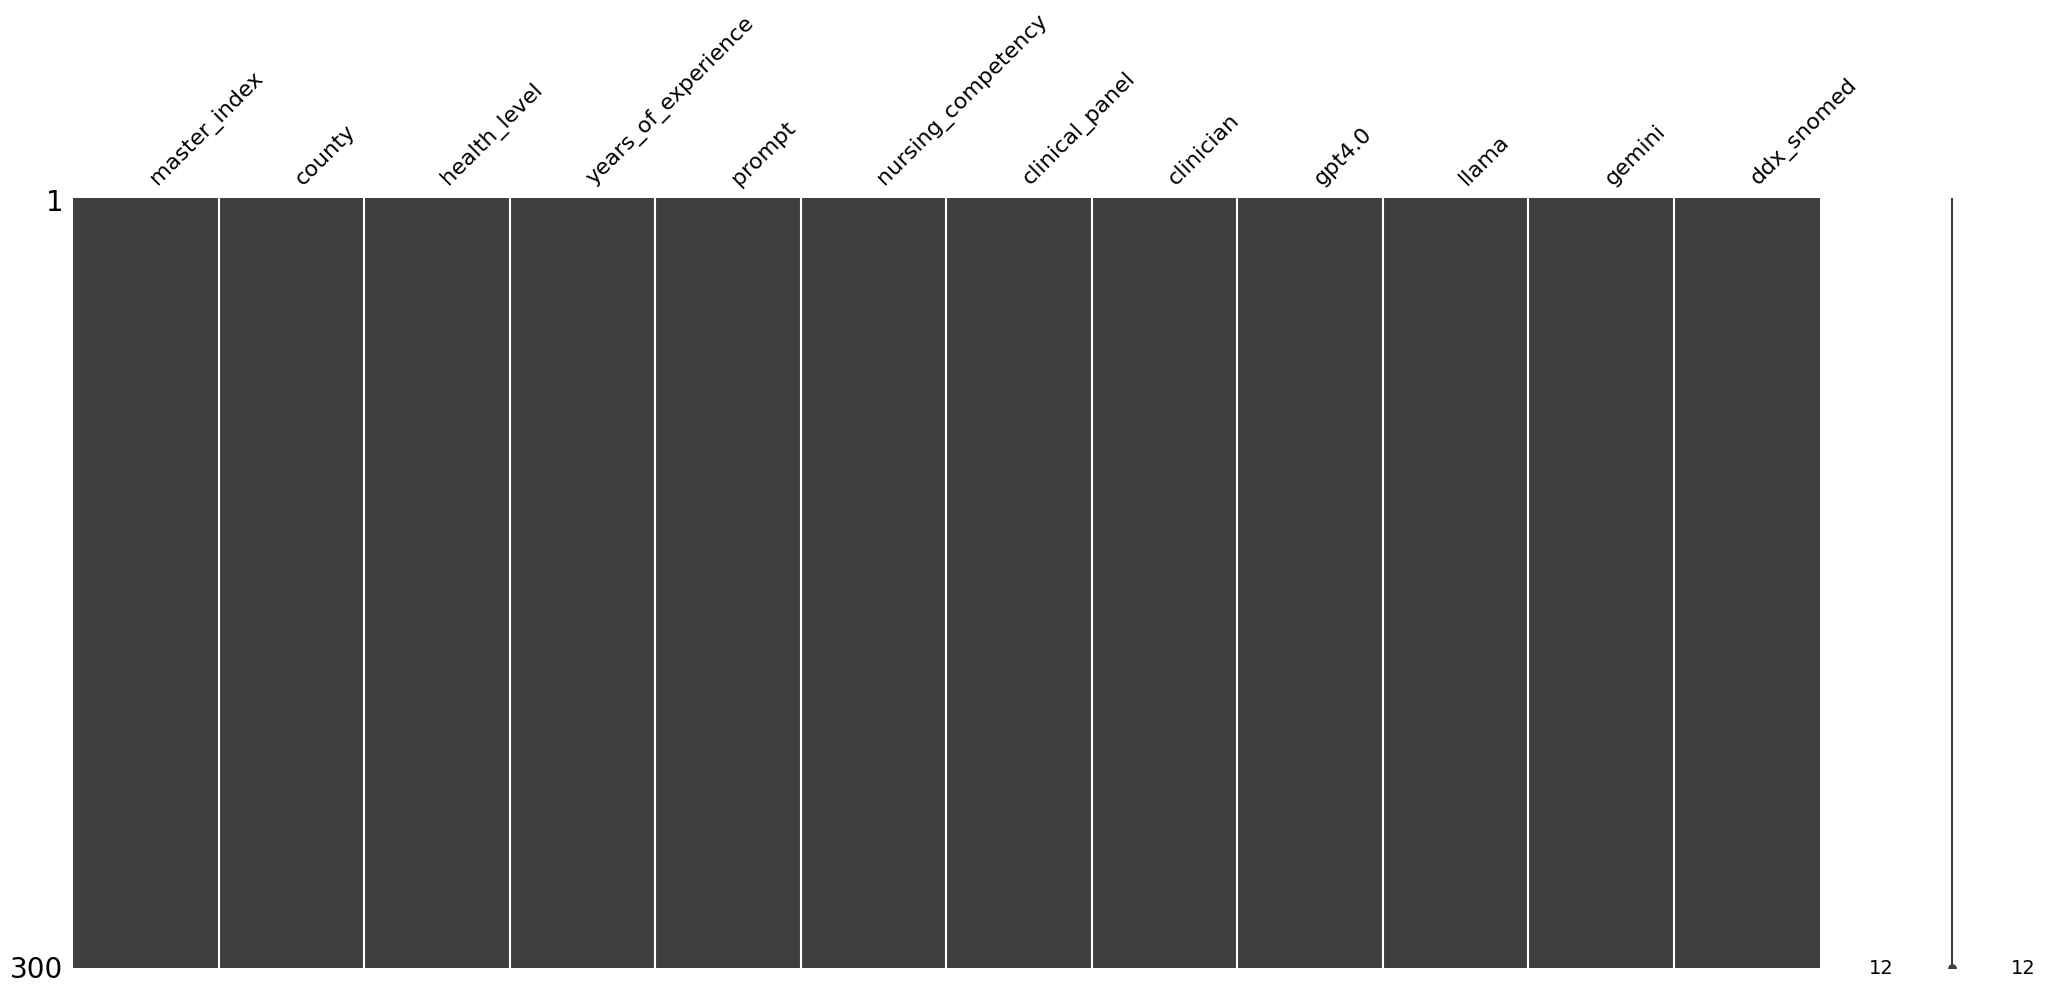

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

df = pd.read_csv('/Users/naomiamadi/Downloads/Documents/Zindi Clinical Reasoning Challenge/cleaned_train.csv')

pd.set_option('display.max_columns', None)  # show all columns

print(df.head())

print(f"Dataset Shape: {df.shape}")

print(f"Columns: {df.columns.tolist()}")

print(df.info())

print(df.describe(include='all'))

missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Missing values:\n", missing_values)

import missingno as msno
msno.matrix(df)
plt.show()

# Check if 'target' column exists
if 'target' in df.columns:
    print(df['target'].value_counts())
    sns.countplot(data=df, x='target')
    plt.title('Target Variable Distribution')
    plt.show()

In [2]:
# Separate categorical and numerical features
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical Columns: {categorical_cols}")
print(f"Numerical Columns: {numerical_cols}")

Categorical Columns: ['master_index', 'county', 'health_level', 'prompt', 'nursing_competency', 'clinical_panel', 'clinician', 'gpt4.0', 'llama', 'gemini', 'ddx_snomed']
Numerical Columns: ['years_of_experience']


In [ ]:
# Histograms for numerical features
df[numerical_cols].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

In [ ]:
# Bar plots for categorical features
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
# Correlation matrix to show correlation between numerical variables (bivariate analysis)
corr = df[numerical_cols].corr()

In [ ]:
# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
#Outlier Detection
# Boxplots for numerical variables
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.show()

In [ ]:
#Feature-Target Relationships
# If 'target' exists
if 'target' in df.columns:
    for col in numerical_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x='target', y=col, data=df)
        plt.title(f'{col} vs Target')
        plt.show()

In [ ]:
#Categorical Features vs Target
# If 'target' exists
if 'target' in df.columns:
    for col in categorical_cols:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=col, hue='target', data=df)
        plt.title(f'{col} vs Target')
        plt.xticks(rotation=45)
        plt.show()

#Summary Observations
# Display some basic summary
print("Summary Observations:")
print("- Dataset shape:", df.shape)
print("- Number of missing values:", missing_values.sum())
print("- Numerical features:", len(numerical_cols))
print("- Categorical features:", len(categorical_cols))
print("- Target distribution (if exists):")
if 'target' in df.columns:
    print(df['target'].value_counts(normalize=True))

In [1]:
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset

# 1. Choose a model and tokenizer
model_name = "distilgpt2"  # Lightweight, good for CPU training
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 2. Add padding token if missing (GPT-2 has none by default)
tokenizer.pad_token = tokenizer.eos_token

# 3. Split into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["prompt"].tolist(),
    df["clinician"].tolist(),
    test_size=0.2,
    random_state=42
)

# 4. Define a custom dataset class
class ClinicalReasoningDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer, max_length=512):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = self.inputs[idx]
        target_text = self.targets[idx]
        encoding = self.tokenizer(
            input_text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        target_encoding = self.tokenizer(
            target_text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()
        labels = target_encoding["input_ids"].squeeze()

        # Replace padding token id's of the labels by -100 so they are ignored by the loss
        labels[labels == tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

# 5. Create datasets
train_dataset = ClinicalReasoningDataset(train_texts, train_labels, tokenizer)
val_dataset = ClinicalReasoningDataset(val_texts, val_labels, tokenizer)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

NameError: name 'df' is not defined

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token  # Add pad token for GPT-2 compatibility

In [2]:
import transformers
print(transformers.__version__)

4.52.4


In [ ]:
from transformers import AutoModelForCausalLM, Trainer, TrainingArguments

# 1. Load the base model for causal language modeling (text generation)
model = AutoModelForCausalLM.from_pretrained("distilgpt2")
model.resize_token_embeddings(len(tokenizer))  # Adjust for any added tokens

# 2. Define training arguments (tuned for CPU)
training_args = TrainingArguments(
    output_dir="./gpt2_clinical_model",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=1,
    push_to_hub=False,         # Disable huggingface hub push
    fp16=False,                # CPU only
    report_to="none"
)

# 3. Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# 4. Start training
trainer.train()

In [ ]:
#Function to generate model outputs
def generate_prediction(prompt, model, tokenizer, max_input_length=200, max_output_length=250):
    # Tokenize the input and truncate if too long
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_length
    ).to(model.device)

    # Generate response
    output_ids = model.generate(
        **inputs,
        max_length=max_output_length,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        num_return_sequences=1
    )

    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [ ]:
#Apply to dataset
df["prediction"] = df["prompt"].apply(lambda x: generate_prediction(x, model, tokenizer))

In [ ]:
df["prediction"]

In [ ]:
submission = df[["master_index", "prediction"]].rename(columns={
    "master_index": "ID",
    "prediction": "Prediction"
})

submission.to_csv("zindi_submission.csv", index=False)

In [ ]:
test_df = pd.read_csv("test.csv")

In [ ]:
test_df["Prediction"] = test_df["Prompt"].apply(lambda x: generate_prediction(x, model, tokenizer))

In [ ]:
submission_df = test_df[["Master_Index", "Prediction"]].rename(columns={
    "Master_Index": "ID"
})
submission_df.to_csv("zindi_submission.csv", index=False)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Load your data
df = pd.read_csv("cleaned_train.csv")

# Use prediction column or fallback
if "prediction" not in df.columns:
    df["prediction"] = df["gpt4.0"]

# BLEU score calculation
smoothie = SmoothingFunction().method4
bleu_scores = [
    sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie)
    for ref, pred in zip(df["clinician"], df["prediction"])
]

# Compute average BLEU
avg_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {round(avg_bleu, 4)}")

In [ ]:
from rouge_score import rouge_scorer

# Load your dataset with ground truth and predictions
df = pd.read_csv("cleaned_train.csv")  # Adjust path if needed

# Use model predictions
if "prediction" not in df.columns:
    df["prediction"] = df["gpt4.0"]  # fallback if custom predictions are not present

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

# Compute ROUGE-L F1 scores for each sample
rouge_l_scores = [
    scorer.score(ref, pred)["rougeL"].fmeasure
    for ref, pred in zip(df["clinician"], df["prediction"])
]

# Calculate average ROUGE-L score
avg_rouge_l = sum(rouge_l_scores) / len(rouge_l_scores)
print(f"Average ROUGE-L F1 Score: {round(avg_rouge_l, 4)}")